In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [44]:
#Load file
Unplanned_read_2024 = pd.read_csv("Unplanned_Hospital_Visits-Hospital_2024.csv")
Unplanned_read_2023 = pd.read_csv("Unplanned_Hospital_Visits-Hospital2023.csv")
Unplanned_read_2022= pd.read_csv("Unplanned_Hospital_Visits-Hospital_2022.csv")
Unplanned_read_2021= pd.read_csv("Unplanned_Hospital_Visits-Hospital2021.csv")
Unplanned_read_2020= pd.read_csv("Unplanned Hospital Visits - Hospital_2020.csv")
hospital_ids = [230017, 230020, 230038, 230058, 230081, 230097, 230110, 230156, 230222, 231320, 233300, 230059,231322]
readmission_dfs = [Unplanned_read_2024, Unplanned_read_2023, Unplanned_read_2022, Unplanned_read_2021, Unplanned_read_2020]

/var/folders/j5/nqhdnxcx2xs_b30brv4h83f40000gn/T/ipykernel_96623/33566688.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  Unplanned_read_2024 = pd.read_csv("Unplanned_Hospital_Visits-Hospital_2024.csv")
/var/folders/j5/nqhdnxcx2xs_b30brv4h83f40000gn/T/ipykernel_96623/33566688.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  Unplanned_read_2023 = pd.read_csv("Unplanned_Hospital_Visits-Hospital2023.csv")
/var/folders/j5/nqhdnxcx2xs_b30brv4h83f40000gn/T/ipykernel_96623/33566688.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  Unplanned_read_2022= pd.read_csv("Unplanned_Hospital_Visits-Hospital_2022.csv")


In [ ]:
## Steps to check the matching columns informations

# Creating a dictionary of columns for each dataframe
columns_dict = {f"Year_{i+1}": set(df.columns) for i, df in enumerate(readmission_dfs)}

# Printing the columns for each year
for year, cols in columns_dict.items():
    print(f"{year} columns:")
    print(cols)
    print("-" * 50)

# Finding common columns across all dataframes
common_cols = set.intersection(*columns_dict.values())
print("✅ Common columns across all DataFrames:")
print(common_cols)

# Finding columns that are unique/missing in each
for year, cols in columns_dict.items():
    missing = common_cols.symmetric_difference(cols)
    if missing:
        print(f"⚠️ Columns needing attention in {year}: {missing}")


In [ ]:
# Selecting four criteria of interest for readmission rate
target_measures = [
    'READM_30_AMI',
    'READM_30_PN',
    'READM_30_HF',
    'READM_30_COPD'
]

# Function to clean and prepare
def prepare_unplanned_read_data(dfs, hospital_ids, target_measures):
    keep_cols = ['Facility ID', 'Facility Name', 'Measure ID', 'Measure Name', 'Score', 'Compared to National','End Date']

    def clean(df):
        df = df.rename(columns={
            # Renaming columns to make it consistent
            'City/Town': 'City',  
            'County/Parish': 'County Name',
            'Telephone Number': 'Phone Number'
        })
        df = df[pd.to_numeric(df['Facility ID'], errors='coerce').notna()]
        df['Facility ID'] = df['Facility ID'].astype(int)
        df = df[df['Facility ID'].isin(hospital_ids)]
        for col in keep_cols:
            if col not in df.columns:
                df[col] = pd.NA
        return df[keep_cols]

    df = pd.concat([clean(d) for d in dfs], ignore_index=True)

    df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
    df['Year'] = pd.to_datetime(df['End Date'], errors='coerce').dt.year
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].astype(int)
    df = df[df['Year'].between(2015, 2025)]
    df['Lean'] = 'YES'  # because every hospital is using lean or other form of lean

    return df[df['Measure ID'].isin(target_measures)]

# Run the function
unplanned_readmission = prepare_unplanned_read_data(readmission_dfs, hospital_ids, target_measures)

# Preview
unplanned_readmission.head(5)

,Facility ID,Facility Name,Measure ID,Measure Name,Score,Compared to National,End Date,Year,Lean
7,230017,BRONSON METHODIST HOSPITAL,READM_30_AMI,Acute Myocardial Infarction (AMI) 30-Day Readm...,11.8,No Different Than the National Rate,06/30/2023,2023,YES
9,230017,BRONSON METHODIST HOSPITAL,READM_30_COPD,Rate of readmission for chronic obstructive pu...,18.1,No Different Than the National Rate,06/30/2023,2023,YES
10,230017,BRONSON METHODIST HOSPITAL,READM_30_HF,Heart failure (HF) 30-Day Readmission Rate,18.1,No Different Than the National Rate,06/30/2023,2023,YES
13,230017,BRONSON METHODIST HOSPITAL,READM_30_PN,Pneumonia (PN) 30-Day Readmission Rate,14.8,No Different Than the National Rate,06/30/2023,2023,YES
21,230020,BEAUMONT HOSPITAL - DEARBORN,READM_30_AMI,Acute Myocardial Infarction (AMI) 30-Day Readm...,14.8,No Different Than the National Rate,06/30/2023,2023,YES
...,...,...,...,...,...,...,...,...,...
895,231322,CHARLEVOIX AREA HOSPITAL,READM_30_PN,Pneumonia (PN) 30-Day Readmission Rate,15.8,No Different Than the National Rate,06/30/2018,2018,YES
903,233300,CHILDREN'S HOSPITAL OF MICHIGAN,READM_30_AMI,Acute Myocardial Infarction (AMI) 30-Day Readm...,NaN,Not Available,06/30/2018,2018,YES
905,233300,CHILDREN'S HOSPITAL OF MICHIGAN,READM_30_COPD,Rate of readmission for chronic obstructive pu...,NaN,Not Available,06/30/2018,2018,YES
906,233300,CHILDREN'S HOSPITAL OF MICHIGAN,READM_30_HF,Heart failure (HF) 30-Day Readmission Rate,NaN,Not Available,06/30/2018,2018,YES


/var/folders/j5/nqhdnxcx2xs_b30brv4h83f40000gn/T/ipykernel_96623/2789894565.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unplanned_read_clean["Year"] = unplanned_read_clean["Year"].astype(int)


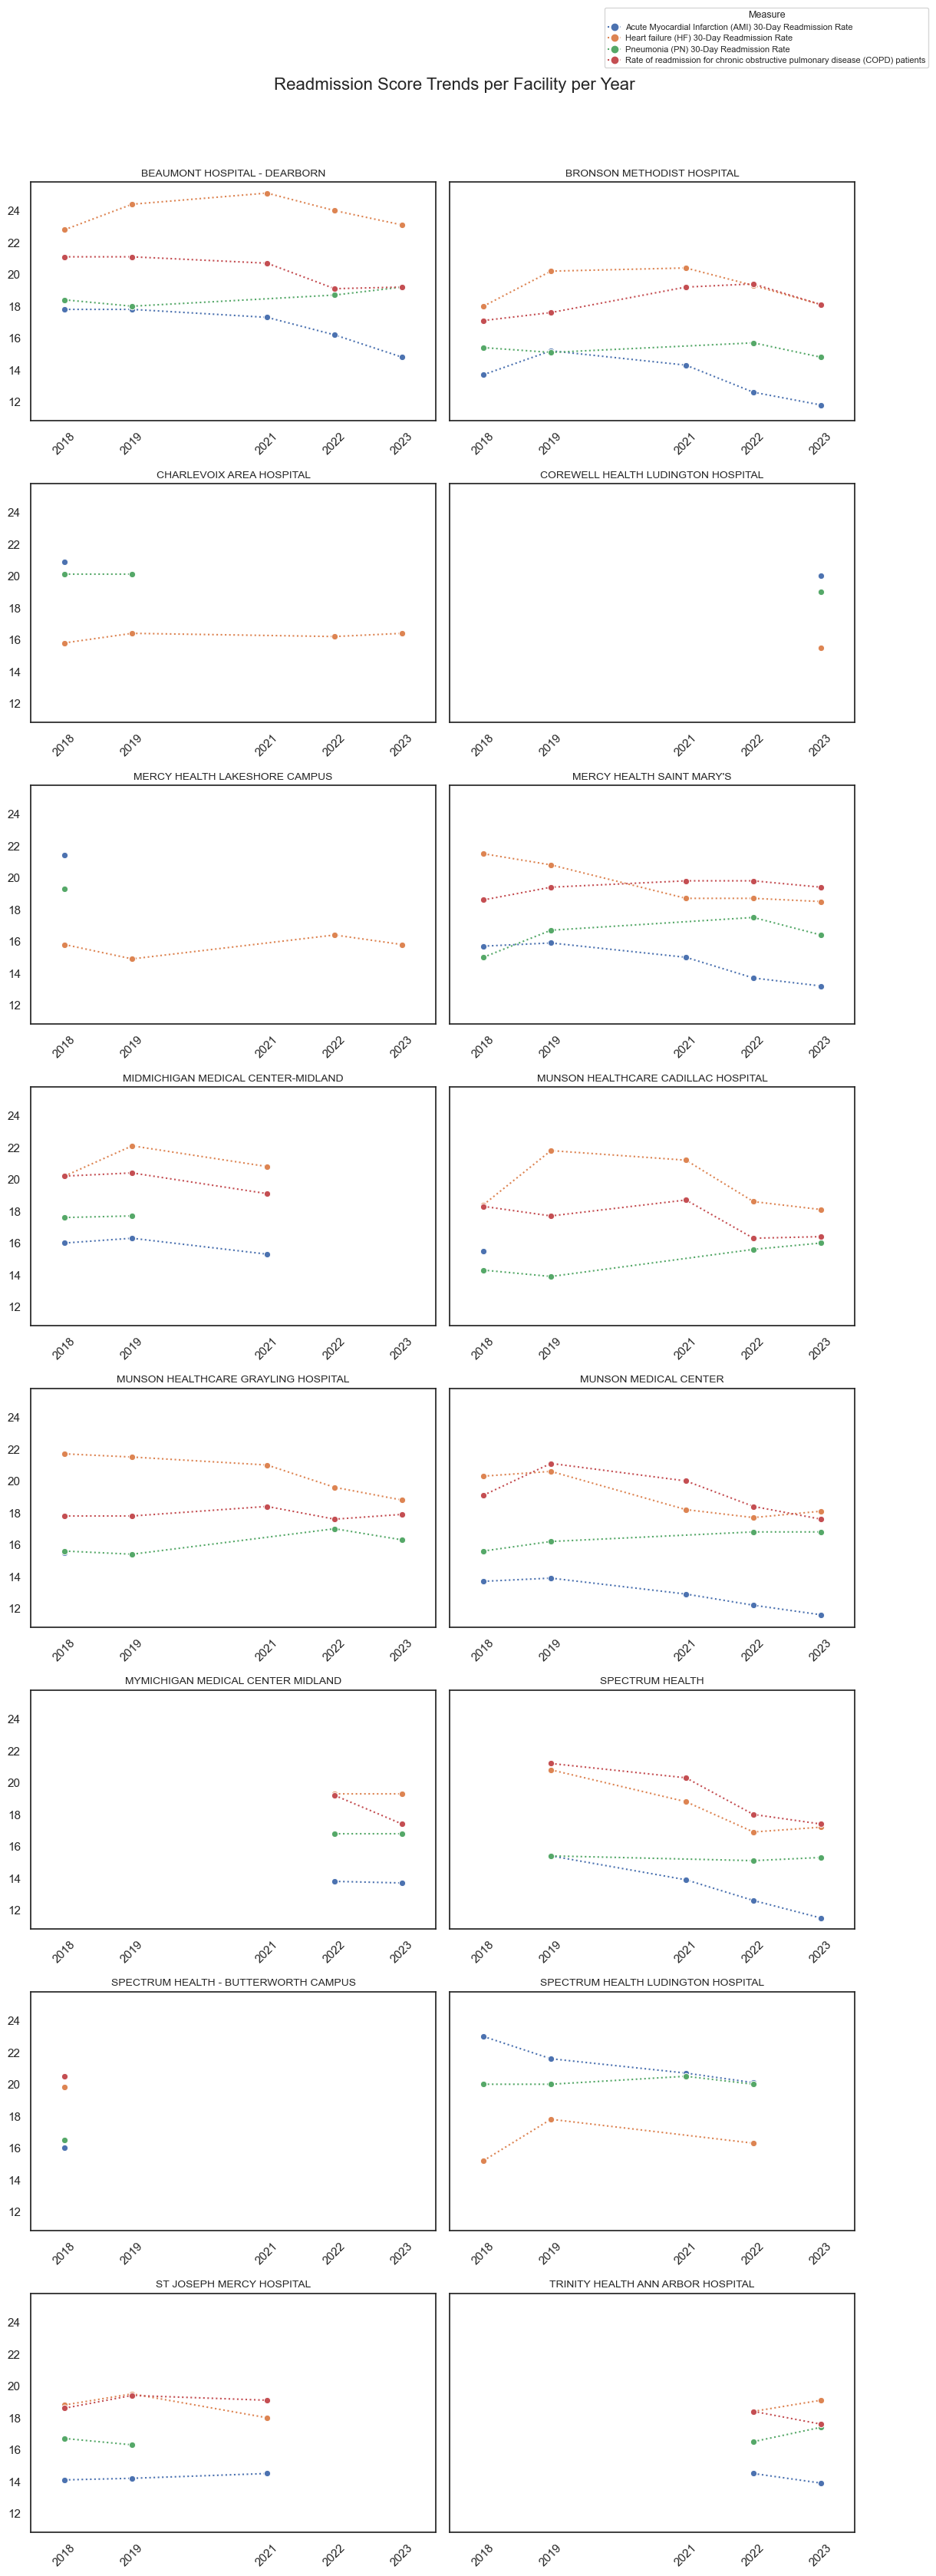

In [ ]:
#Visualization of the result

# 1. Clean and preprocess, just for making it sure
unplanned_read_clean = unplanned_readmission.dropna(subset=["Score"])
unplanned_read_clean["Year"] = unplanned_read_clean["Year"].astype(int)

# 2. Group by Facility, Measure, and Year and get average score
avg_scores_unplanned = (
    unplanned_read_clean.groupby(["Facility Name", "Measure Name", "Year"], as_index=False)
    .agg(avg_score=("Score", "mean"))
)

# 3. Unique years, facilities, measures
years = sorted(avg_scores_unplanned["Year"].unique())
min_year, max_year = min(years), max(years)
facilities = avg_scores_unplanned["Facility Name"].unique()
unique_measures = avg_scores_unplanned["Measure Name"].unique()
n_facilities = len(facilities)

# 4. Set up plot grid
n_cols = 2
n_rows = (n_facilities + n_cols - 1) // n_cols
sns.set(style="white")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharey=True)
axes = axes.flatten()

# 5. Plot each facility
for i, facility in enumerate(facilities):
    ax = axes[i]
    data = avg_scores_unplanned[avg_scores_unplanned["Facility Name"] == facility]

    sns.lineplot(
        data=data,
        x="Year",
        y="avg_score",
        hue="Measure Name",
        marker="o",
        linestyle=":",
        ax=ax,
        legend=False  # No individual legends
    )

    ax.set_title(facility, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(min_year - 0.5, max_year + 0.5)
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)

# 6. Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 7. Shared legend
palette = sns.color_palette(n_colors=len(unique_measures))
legend_handles = [
    Line2D([0], [0], color=palette[i], marker='o', linestyle=':', label=measure)
    for i, measure in enumerate(unique_measures)
]

fig.legend(
    handles=legend_handles,
    title="Measure",
    title_fontsize=9,
    fontsize=8,
    loc='upper right',
    bbox_to_anchor=(1.02, 1.05),
    frameon=True,
    borderpad=0.4,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.5
)

# 8. Add overall title and layout
plt.suptitle("Readmission Score Trends per Facility per Year", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for the legend
plt.savefig("unplanned_readmission_trends_per_facility.png", dpi=300, bbox_inches='tight')
plt.show()
